In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


Bad key text.latex.preview in file C:\Users\mathe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\mathe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\mathe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

## Load and pre process data

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
player_data = pd.read_csv("DataCollection/Player_Stats/player_stats_2021-22.csv")

In [4]:
shooting_data = pd.read_csv("DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_2021-22.csv")

In [5]:
player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%'])], on=['Player', 'Tm'])

In [7]:
player_data = player_data.fillna(0)
player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
player_data = player_data.sort_values(by=['G'], ascending=False)
player_data = player_data[player_data["Tm"] != "TOT"]
player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
player_data.reset_index(inplace=True)
player_data.drop(columns=['index'], inplace=True)

## Normalize the data

In [8]:
features = player_data.loc[:, ~player_data.columns.isin(["Player", "Pos", "Tm"])].values
x = StandardScaler().fit_transform(features)

## Reduce Dimensionality to 2 components

In [9]:
pca = PCA(n_components=2)
components = pca.fit_transform(x)

componentsDf = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])
finalDf = pd.concat([componentsDf, player_data[['Pos', "Player"]]], axis = 1)

### Plot 2D PCA

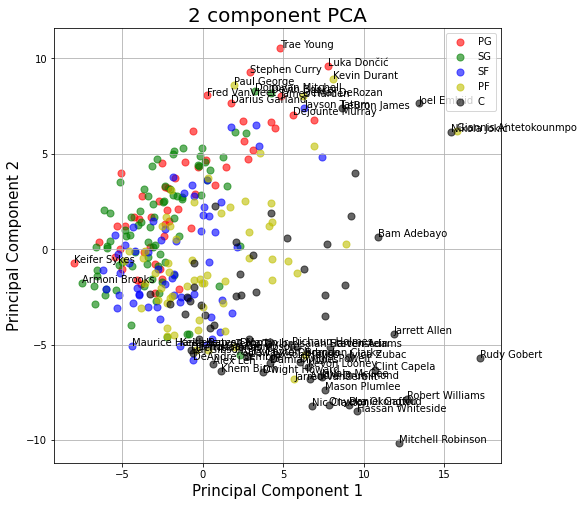

In [10]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['PG', 'SG', 'SF', 'PF', 'C']
colors = ['r', 'g', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Pos'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], 
               c=color, s=50, alpha=.6)
ax.legend(targets)
ax.grid()

for i, data in finalDf.iterrows():
    if data["PC1"] < -7 or data["PC2"] > 7 or data["PC1"] > 10 or data["PC2"] < -5:
        ax.annotate(data["Player"], (data["PC1"], data["PC2"]))

# Clustering

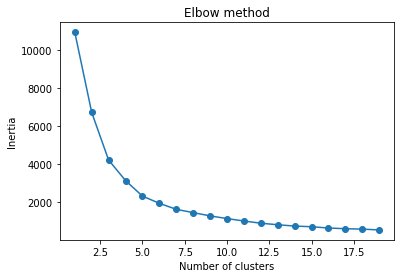

In [11]:
data = list(zip(finalDf["PC1"], finalDf["PC2"]))

inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Run K-means

In [12]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)
cmap = plt.cm.get_cmap('Dark2', 5)
finalDf['Cluster'] = kmeans.labels_

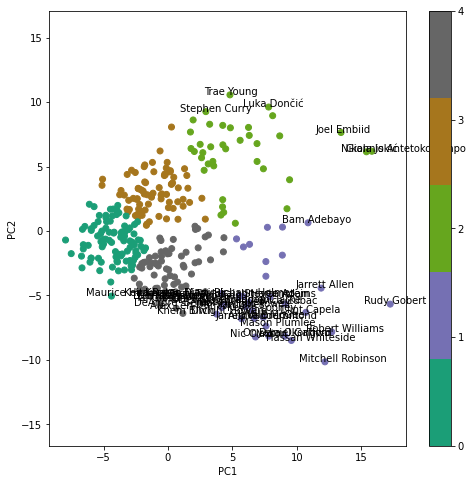

In [13]:
plt.figure(figsize=(8, 8))
plt.scatter(finalDf["PC1"], finalDf["PC2"], c=finalDf['Cluster'], cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
for i, row in finalDf.iterrows():
    if row["PC1"] < -10 or row["PC2"] > 9 or row["PC1"] > 10 or row["PC2"] < -5:
        plt.text(row["PC1"]-2, row["PC2"], row["Player"])
plt.axis('equal')
plt.colorbar(ticks=[0, 1, 2, 3, 4])
plt.show()

## Randomizing PCA features

In [14]:
def run_random_pca(df, non_feature_cols, target):
    features = df.loc[:, ~df.columns.isin(non_feature_cols)]
    random_selector = np.random.choice(a=[False, True], size=len(features.columns), p=[.5, .5])
    random_features_df = features.loc[:, random_selector]
    selected_features = list(random_features_df.columns)
    random_features = random_features_df.values        
    random_features = StandardScaler().fit_transform(random_features)
    
    pca = PCA(2)
    components = pca.fit_transform(random_features)
    components_df = pd.DataFrame(data=components, columns=["PC1", "PC2"])
    components_df = pd.concat([components_df, df[target]], axis=1)
    var = pca.explained_variance_ratio_
    return components_df, [selected_features, len(selected_features), var[0], var[1], sum(var)]

In [15]:
PCAs = pd.DataFrame(columns=["Features", "Features Count", "PC1 var", "PC2 var", "Total explained variance ratio"])

In [ ]:
for i in range(10**5):
    df, pca_stats = run_random_pca(player_data, ["Player", "Pos", "Tm"], ["Player", "Pos"])
    pca_row = {'Features': ' '.join(pca_stats[0]),
               'Features Count': pca_stats[1],
               'PC1 var': pca_stats[2],
               'PC2 var': pca_stats[3],
               'Total explained variance ratio': pca_stats[4]}
    PCAs = PCAs.append(pca_row, ignore_index=True)

In [ ]:
PCAs.to_csv("DataCollection/PCA/random_PCAs_playerData.csv", index=False)

In [16]:
PCAs = pd.read_csv("DataCollection/PCA/random_PCAs_playerData.csv")

In [17]:
PCAs.sort_values(by='Total explained variance ratio', ascending=False, inplace=True)

In [18]:
features = player_data[PCAs.iloc[0]['Features'].split()] 
x = StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
components = pca.fit_transform(x)

componentsDf = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])
df = pd.concat([componentsDf, player_data[['Pos', "Player"]]], axis = 1)

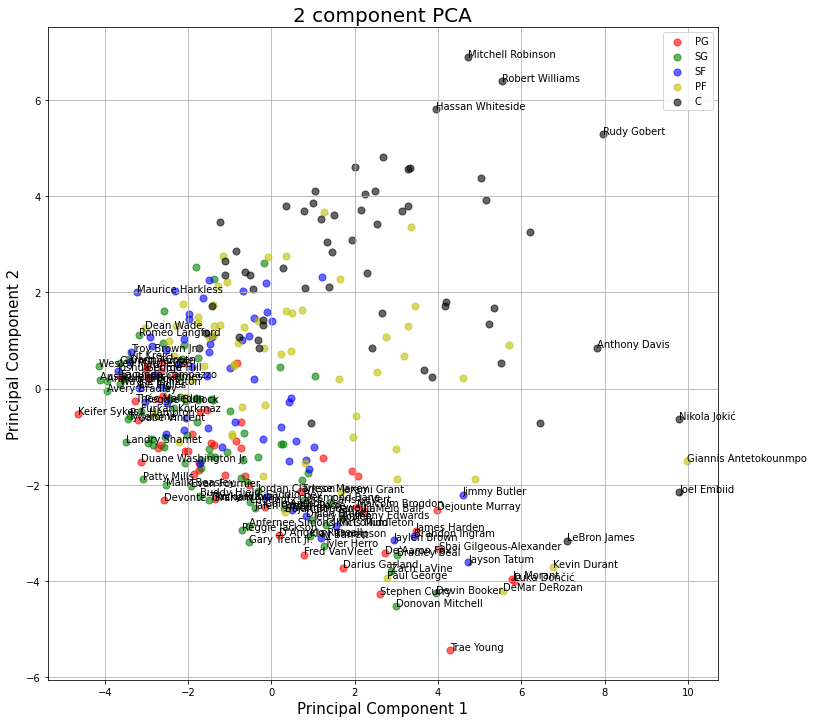

In [19]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['PG', 'SG', 'SF', 'PF', 'C']
colors = ['r', 'g', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = df['Pos'] == target
    ax.scatter(df.loc[indicesToKeep, 'PC1'], df.loc[indicesToKeep, 'PC2'], 
               c=color, s=50, alpha=.6)
ax.legend(targets)
ax.grid()

for i, data in df.iterrows():
    if data["PC1"] < -3 or data["PC2"] > 5 or data["PC1"] > 7.5 or data["PC2"] < -2:
        ax.annotate(data["Player"], (data["PC1"], data["PC2"]))

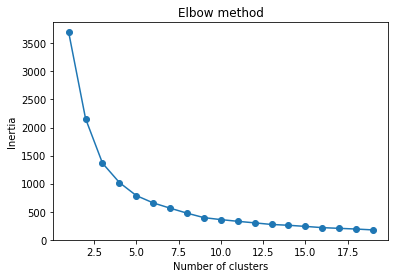

In [20]:
data = list(zip(df["PC1"], df["PC2"]))

inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [21]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)
cmap = plt.cm.get_cmap('Dark2', 5)
df['Cluster'] = kmeans.labels_

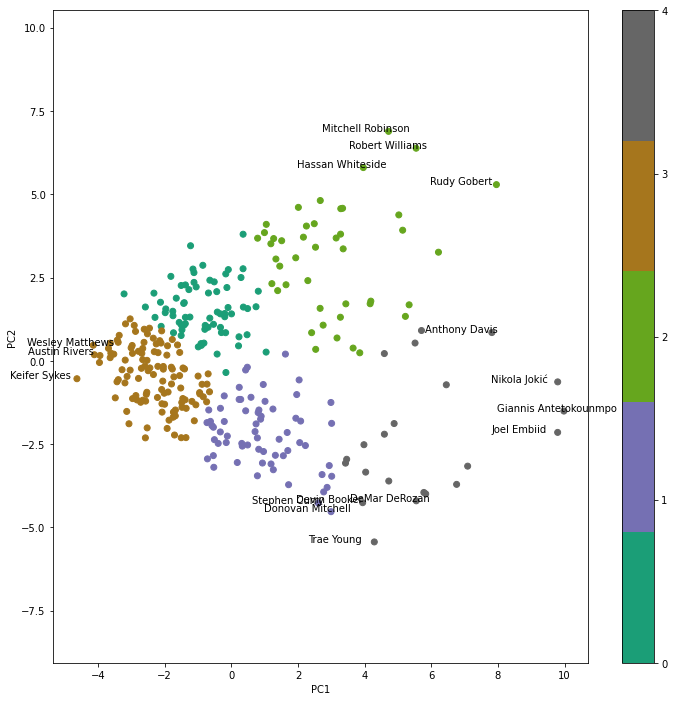

In [22]:
plt.figure(figsize=(12, 12))
plt.scatter(df["PC1"], df["PC2"], c=df['Cluster'], cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
for i, row in df.iterrows():
    if row["PC1"] < -4 or row["PC2"] > 5 or row["PC1"] > 7.5 or row["PC2"] < -4:
        plt.text(row["PC1"]-2, row["PC2"], row["Player"])
plt.axis('equal')
plt.colorbar(ticks=[0, 1, 2, 3, 4])
plt.show()